In [46]:
#!pip install requests
!pip install tqdm

     |████████████████████████████████| 71kB 1.9MB/s eta 0:00:011


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests # For API requests
import json # For API requests
import time # To delay API & web scrapping pulls to avoid crashes
from tqdm import tqdm #to see progres of loop

pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 100)

In [2]:
links = pd.read_csv('./movielens_data/links.csv', index_col=0)
movies = pd.read_csv('./movielens_data/movies.csv')
ratings = pd.read_csv('./movielens_data/ratings.csv')
tags = pd.read_csv('./movielens_data/tags.csv')

In [83]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies.head();

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head();

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags.head();

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
df_ratings = ratings.drop('timestamp', axis=1)

In [14]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge  scikit-surprise

____________________________________________

In [7]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

In [16]:
genre_count = pd.DataFrame(keyword_occurences, columns = ['genre', 'count'], index =genre_count.genre)

In [17]:
genre_count.iloc[0]

genre    Drama
count     4361
Name: Drama, dtype: object

In [18]:
genre_count.head()

,genre,count
genre,,
Drama,Drama,4361
Comedy,Comedy,3756
Thriller,Thriller,1894
Action,Action,1828
Romance,Romance,1596


In [19]:
type(genre_count)

pandas.core.frame.DataFrame

In [20]:
genre_count.columns

Index(['genre', 'count'], dtype='object')

<Figure size 432x288 with 0 Axes>

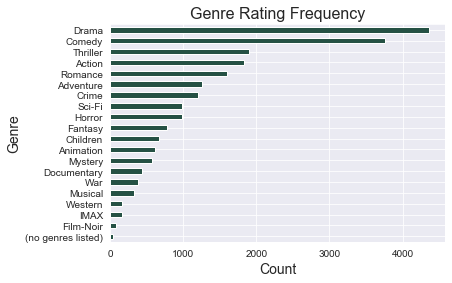

In [81]:
fig, ax = plt.subplots(0)
sns.set_style('darkgrid')
ax = genre_count.sort_values(by='count').plot(kind='barh', legend=False, color='#255144')
ax.set_ylabel('Genre',fontsize=14)
ax.set_xlabel('Count', fontsize=14)
ax.set_title('Genre Rating Frequency', fontsize=16)
plt.savefig('./movielens_data/genre_rating_freq.png', dpi=200)
plt.show()

In [84]:
rate = ratings['rating'].value_counts().sort_index(ascending=False)

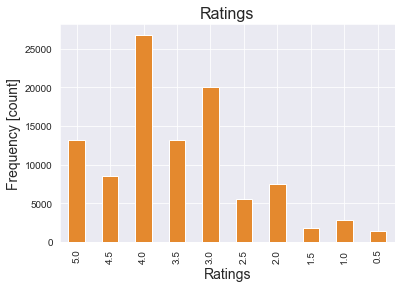

In [85]:
fig, ax = plt.subplots()
sns.set_style('darkgrid')
ax = rate.plot(kind="bar", color='#e4892e')
ax.set_ylabel('Frequency [count]',fontsize=14 )
ax.set_xlabel('Ratings', fontsize=14)
ax.set_title('Ratings', fontsize=16)
plt.savefig('./movielens_data/ratings_freq.png', dpi=200)
plt.show()

In [34]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [35]:
ratings.rating.mode()

0    4.0
dtype: float64

The data is very symmetric signifying the mean and median are very close and that there is no skew present towards any grouping or singular rating value. The standard deviation is approximately 1 signaling that the data is is fairly well clustered around the mean. and the most common rating was a 4.0. Signifying most titles are rated fairly highly or the value of this rating represents some measure of neutrality.

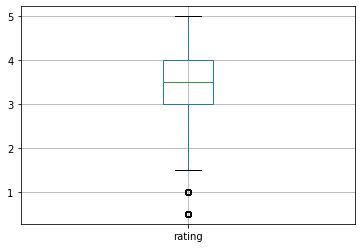

In [36]:
ratings.boxplot(column = 'rating')

In [37]:
mv_ratings = ratings.merge(movies, on='movieId', how = 'inner')
mv_ratings.drop(columns=['title', 'genres', 'timestamp'], inplace = True)

In [38]:
mv_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


In [39]:
# re-express movie ids in correct imdb format
imdb = links['imdbId'].values.astype(str)  #converted list type into string

In [40]:
def correct_imdb_ids(imdb):  
    imdb_ids = []
    for ids in imdb:
        if len(ids) == 3:
            imdb_ids.append('tt0000'+ids)
        elif len(ids) == 4:
            imdb_ids.append('tt000'+ids)
        elif len(ids) == 5:
            imdb_ids.append('tt00'+ids)
        elif len(ids) == 6:
            imdb_ids.append('tt0'+ids)
        elif len(ids) == 7:
            imdb_ids.append('tt'+ids)   
    return imdb_ids    #created function to correct the format of the IMDB ID's (need in order to do correct API pull)

In [41]:
imdb_ids = correct_imdb_ids(imdb)  #tested function to see if it worked properly
imdb_ids[:5]

['tt0114709', 'tt0113497', 'tt0113228', 'tt0114885', 'tt0113041']

In [42]:
len(imdb_ids)

9742

In [48]:
api_key = '49fc59a029e4df5ad29e6be556dae829'

In [49]:
# source imdb data for rated movies.
imdb_data = []
for ids in tqdm(imdb_ids):
    request = requests.get('https://api.themoviedb.org/3/movie/' + ids + '?api_key=' + api_key + '&language=en-US')
    time.sleep(.200)
    i = request.json()
    imdb_data.append(i)
print(imdb_data)

100%|██████████| 9742/9742 [53:44<00:00,  3.02it/s]  
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [50]:
total_mdb = pd.DataFrame.from_dict(imdb_data)
total_mdb.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,False,/lxD5ak7BOoinRNehOCA85CQ8ubr.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",59.243,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.9,12892.0,NaN,NaN,NaN
1,False,/y7SQmjlB42VvYyRIFQXLQ4ZYrn.jpg,"{'id': 495527, 'name': 'Jumanji Collection', '...",65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.sonypictures.com/movies/jumanji/,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,10.067,/bdHG5Mo83VPobeZZdlSz0Y7HQHB.jpg,"[{'id': 559, 'logo_path': '/eC0bWHVjnjUducyA6Y...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,7.2,7534.0,NaN,NaN,NaN
2,False,/1J4Z7VhdAgtdd97nCxY7dcBpjGT.jpg,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.425,/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg,"[{'id': 19464, 'logo_path': None, 'name': 'Lan...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.6,208.0,NaN,NaN,NaN
3,False,/yibpm3qFap62p92GL2mP71cevS9.jpg,None,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",7.669,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,"[{'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVR...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.2,78.0,NaN,NaN,NaN
4,False,/wKQlgHjJwh5mGBZ37vDsXBx9zbh.jpg,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,13.231,/lf9RTErt8BSLQy98aSFblElvsCQ.jpg,"[{'id': 9195, 'logo_path': '/ou5BUbtulr6tIt699...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-08,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,6.2,431.0,NaN,NaN,NaN


In [52]:
# Save dataset to bypass possible future api calling.
total_mdb.to_csv('./movielens_data/total_mdb.csv')

In [54]:
# merge movies and links data
links['imdb_id'] = imdb_ids

In [55]:
# merge movie, ratings datasets
mv_ratings = ratings.merge(movies, on = 'movieId', how ='inner')  #merging the movie and rating Data Frames
mv_ratings.drop(columns=['timestamp','genres'], inplace = True)

In [56]:
mv_ratings.head();

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [57]:
# now merge imdb link list with mv_ratings df
links_mv_df = mv_ratings.merge(links, on = 'movieId', how ='inner') 
links_mv_df.drop(columns=['tmdbId','imdbId'], inplace = True)
links_mv_df.head()

,userId,movieId,rating,title,imdb_id
0,1,1,4.0,Toy Story (1995),tt0114709
1,5,1,4.0,Toy Story (1995),tt0114709
2,7,1,4.5,Toy Story (1995),tt0114709
3,15,1,2.5,Toy Story (1995),tt0114709
4,17,1,4.5,Toy Story (1995),tt0114709


In [61]:
#now final merge with API data -> merge API data with rating data on IMDB ID
complete_df = links_mv_df.merge(total_mdb, on = 'imdb_id', how ='inner')  

#drop extraneous columns
complete_df.drop(columns=['homepage','tagline','backdrop_path','belongs_to_collection', 'original_language','vote_count','status_message',
               'poster_path','adult','id','original_title', 'production_companies', 'production_countries','status_code',
               'overview','spoken_languages','status','title_y','video','vote_average','success'], inplace = True)


In [62]:
complete_df.head()

,userId,movieId,rating,title_x,imdb_id,budget,genres,popularity,release_date,revenue,runtime,success
0,1,1,4.0,Toy Story (1995),tt0114709,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",59.243,1995-10-30,373554033.0,81.0,NaN
1,5,1,4.0,Toy Story (1995),tt0114709,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",59.243,1995-10-30,373554033.0,81.0,NaN
2,7,1,4.5,Toy Story (1995),tt0114709,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",59.243,1995-10-30,373554033.0,81.0,NaN
3,15,1,2.5,Toy Story (1995),tt0114709,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",59.243,1995-10-30,373554033.0,81.0,NaN
4,17,1,4.5,Toy Story (1995),tt0114709,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",59.243,1995-10-30,373554033.0,81.0,NaN


In [65]:
complete_df.dtypes

userId            int64
movieId           int64
rating          float64
title_x          object
imdb_id          object
budget          float64
genres           object
popularity      float64
release_date     object
revenue         float64
runtime         float64
dtype: object

### Hypothesis Testing

Because this recommendation system is issuing predictions based on predicted ratings, it seemed pertinent to explore the relationship between ratings issued  and other factors in order to contextualize the recommender.

In [66]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy import stats

In [67]:
stats.f_oneway(complete_df['budget'][complete_df['rating'] == 0.5],
               complete_df['budget'][complete_df['rating'] == 1.0],
               complete_df['budget'][complete_df['rating'] == 1.5],
               complete_df['budget'][complete_df['rating'] == 2.0],
               complete_df['budget'][complete_df['rating'] == 2.5],
               complete_df['budget'][complete_df['rating'] == 3.0],
               complete_df['budget'][complete_df['rating'] == 3.5],
               complete_df['budget'][complete_df['rating'] == 4.0],
               complete_df['budget'][complete_df['rating'] == 4.5],
               complete_df['budget'][complete_df['rating'] == 5.0])

F_onewayResult(statistic=67.35532859388148, pvalue=2.38160455615462e-124)

H_0: There is no statistically significant difference between the budget of a movie and its movie rating.

H_A: There is not a statistically significant difference between the budget of a movie and its movie rating

Result:

**p << alpha=0.05 : we reject the null hypothesis and conclude there is a statistically significant difference between ratings across production budgets**

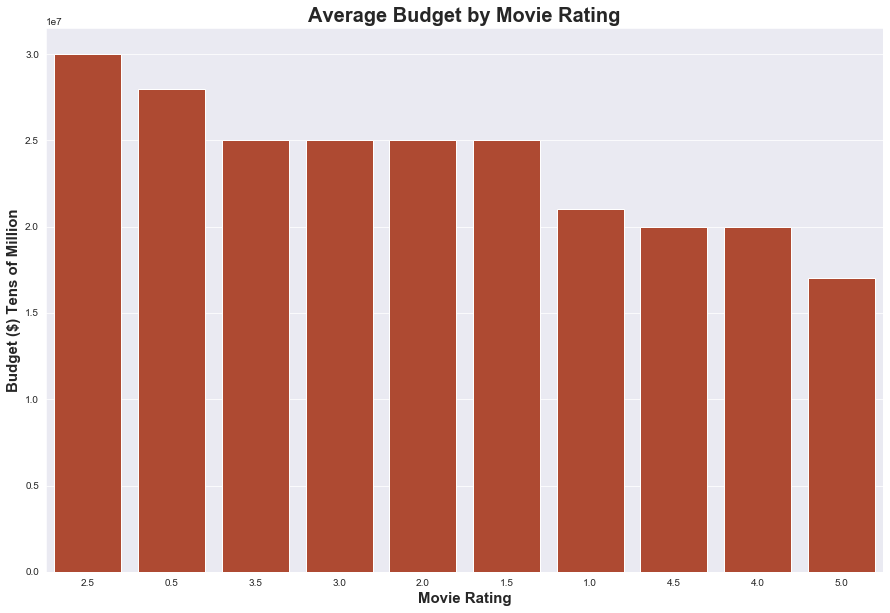

In [86]:
x = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).keys()
y = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).values
sns.set_style('darkgrid')
fig,ax=plt.subplots(figsize=(15,10))

sns.barplot(x, y, order = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).keys(),
           color = '#c33d1d')
ax.set_xlabel('Movie Rating',fontweight='bold', fontsize=(15))
ax.set_ylabel('Budget ($) Tens of Million', fontweight='bold', fontsize=(15))
ax.set_title('Average Budget by Movie Rating', fontweight='bold', fontsize=(20))
plt.savefig('avg_budget_mvrating.png', dpi=200)